In [24]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [25]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time
import pprint
import copy
from functools import reduce

# external dependencies
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms
# %load_ext autoreload
# %autoreload 2
%matplotlib inline

# Data Summary Stats

First load in the data and do a little cleanup

In [26]:
C19 = pd.read_csv("../data/CYP2C19_abundance.csv")
C9 = pd.read_csv("../data/CYP2C9_abundance.csv")

append df's and add condition id, rename for MultiDmsData

In [27]:
rename_map = {
    "variant" : "aa_substitutions"
}
func_score_df = pd.concat(
    [
        C19.assign(condition="C19"), 
        C9.assign(condition="C9")
    ]
).rename(rename_map,axis=1)

remove 'syn' mutants

In [28]:
func_score_df = func_score_df[~func_score_df.aa_substitutions.str.contains("syn")]

conform 'X' -> '*' for stop codon variants

In [29]:
func_score_df = func_score_df.assign(aa_substitutions = func_score_df.aa_substitutions.str.replace("X", "*"))

add log fold change of weighted average.

In [30]:
func_score_df = func_score_df.assign(log_fold_wa = onp.log2(func_score_df.weighted_average / func_score_df.wt_wa))

In [31]:
func_score_df

,replicate,sort,barcode,weighted_average,total_reads,freq,type,med_nonsense,wt_wa,abundance_score,aa_substitutions,start,position,end,condition,log_fold_wa
0,Rep2,1.0,AAAAAAAACTACGTTCCA,0.844684,234,0.000008,missense,0.291621,0.826506,1.033983,S162R,S,162,R,C19,0.031385
1,Rep2,1.0,AAAAAAAATCCTAGCCGT,0.563894,937,0.000039,missense,0.291621,0.826506,0.509032,D373R,D,373,R,C19,-0.551601
2,Rep2,1.0,AAAAAAAATTTTGAAAGA,0.681836,959,0.000038,missense,0.291621,0.826506,0.729530,D360K,D,360,K,C19,-0.277602
3,Rep2,1.0,AAAAAAACTATTGACTTC,0.751838,217,0.000008,missense,0.291621,0.826506,0.860404,L71G,L,71,G,C19,-0.136604
4,Rep2,1.0,AAAAAAATACAGGTTAAT,0.304310,215,0.000017,nonsense,0.291621,0.826506,0.023724,E274*,E,274,X,C19,-1.441484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102104,Rep3,NaN,TTTTTTTTGAAAGTCAAG,0.706138,188,0.000070,missense,0.423188,0.701742,1.015779,K247A,K,247,A,C9,0.009008
102105,Rep3,NaN,TTTTTTTTGCCAACGAAG,0.647242,166,0.000065,missense,0.423188,0.701742,0.804345,D191T,D,191,T,C9,-0.116636
102106,Rep3,NaN,TTTTTTTTGTAATTCTTG,0.692603,103,0.000038,missense,0.423188,0.701742,0.967191,Q193L,Q,193,L,C9,-0.018912
102107,Rep3,NaN,TTTTTTTTGTACGTACTT,0.496281,104,0.000044,missense,0.423188,0.701742,0.262400,G332S,G,332,S,C9,-0.499785


Summary stats of quantitative columns

In [32]:
func_score_df.describe()

,sort,weighted_average,total_reads,freq,med_nonsense,wt_wa,abundance_score,position,log_fold_wa
count,421147.000000,519020.000000,519020.000000,5.190200e+05,519020.000000,519020.000000,519020.000000,519020.000000,519020.000000
mean,1.494098,0.626921,438.002173,4.301402e-05,0.326916,0.750214,0.709008,232.082633,-0.313643
std,0.499966,0.169343,514.979630,4.049830e-05,0.053164,0.060527,0.404777,128.451178,0.425038
min,1.000000,0.250000,1.000000,1.830817e-08,0.289502,0.666583,-0.701318,1.000000,-1.725098
25%,1.000000,0.500000,129.000000,1.549856e-05,0.291621,0.701742,0.418477,129.000000,-0.555116
50%,1.000000,0.634832,266.000000,3.189474e-05,0.291848,0.741439,0.724179,230.000000,-0.234487
75%,2.000000,0.751922,534.000000,5.738337e-05,0.338143,0.806834,0.998251,342.000000,-0.001403
max,2.000000,1.000000,10376.000000,6.549612e-04,0.437047,0.826506,2.110753,490.000000,0.585142


**Why** is there so much more data for C19?

In [33]:
func_score_df.condition.value_counts()

condition
C19    421147
C9      97873
Name: count, dtype: int64

In [34]:
func_score_df.query("condition == 'C19'").replicate.value_counts()

replicate
Rep2    212375
Rep3    208772
Name: count, dtype: int64

In [35]:
func_score_df.query("condition == 'C9'").replicate.value_counts()

replicate
Rep2    48946
Rep3    48927
Name: count, dtype: int64

## Functional scores distributions

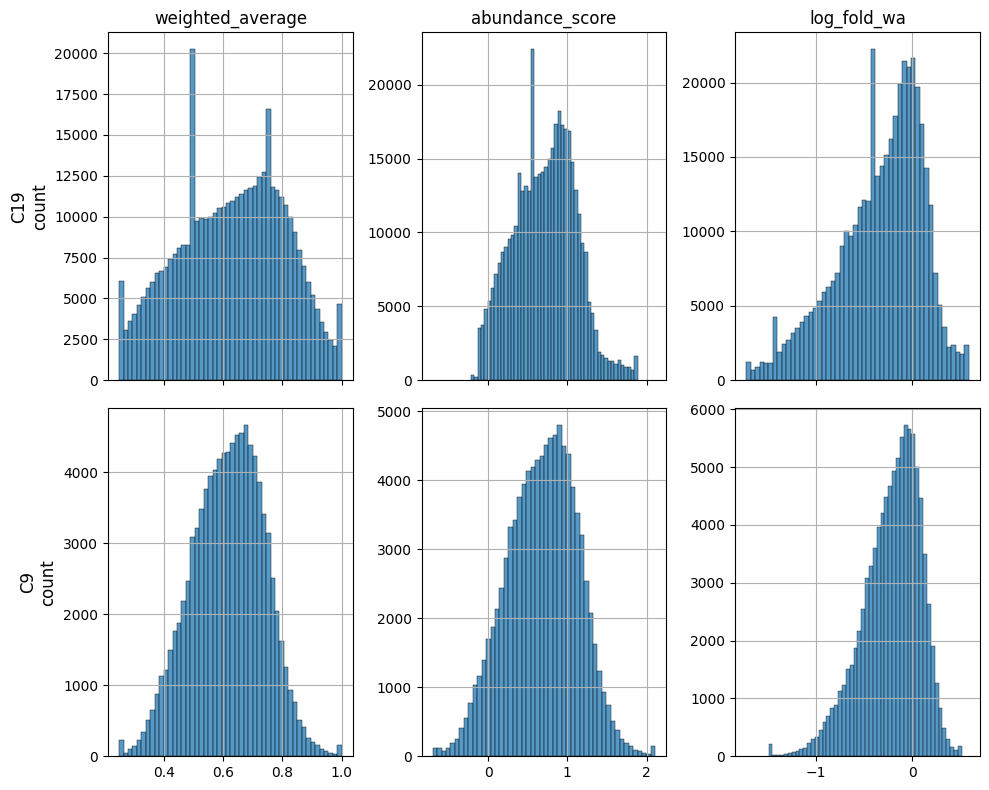

In [36]:
targets = ["weighted_average", "abundance_score", "log_fold_wa"]
fig, ax = plt.subplots(
    len(func_score_df.condition.unique()),
    len(targets),
    sharex="col",
    figsize=[10, 8]
)
for row, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    for col, target in enumerate(targets):
        sns.histplot(condition_df, x=target, ax=ax[row, col], bins=50)
        ax[row, col].grid()
        ax[row, col].set_xlabel("")
        ax[row, col].set_ylabel("")
        if col == 0:
            ax[row, col].set_ylabel(f"{condition}\ncount", size=12)
        if row == 0:
            ax[row, col].set_title(target)
plt.tight_layout()
plt.show()

## Barcodes

First, we'll look at the number of barcodes per variant

In [37]:
for col, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    vc = condition_df.aa_substitutions.value_counts()
    print(condition,'\n',vc.describe())

C19 
 count    8472.000000
mean       49.710458
std        64.122068
min         1.000000
25%        12.000000
50%        28.000000
75%        62.000000
max      1457.000000
Name: count, dtype: float64
C9 
 count    8308.000000
mean       11.780573
std        12.594819
min         1.000000
25%         4.000000
50%         8.000000
75%        14.000000
max       172.000000
Name: count, dtype: float64


In [38]:
list(range(0, 10, 2))

[0, 2, 4, 6, 8]

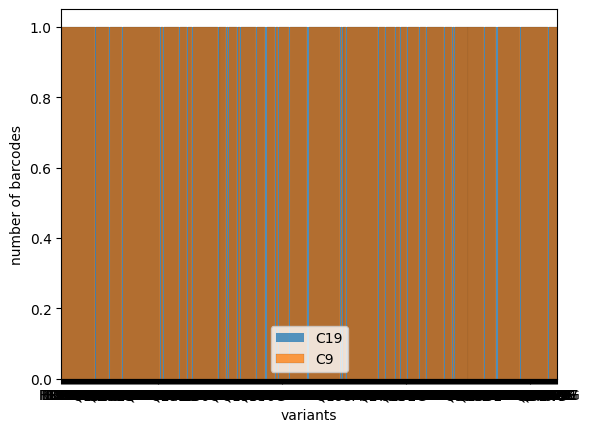

In [39]:
fig, ax = plt.subplots()
for col, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    vc = condition_df.aa_substitutions.value_counts().reset_index()
    sns.histplot(vc, x="aa_substitutions", ax=ax, bins=range(0, 500, 10), label=condition)
    ax.set_ylabel("number of barcodes")
    ax.set_xlabel("variants")
    ax.set_xlim([0, 500])
    ax.legend()

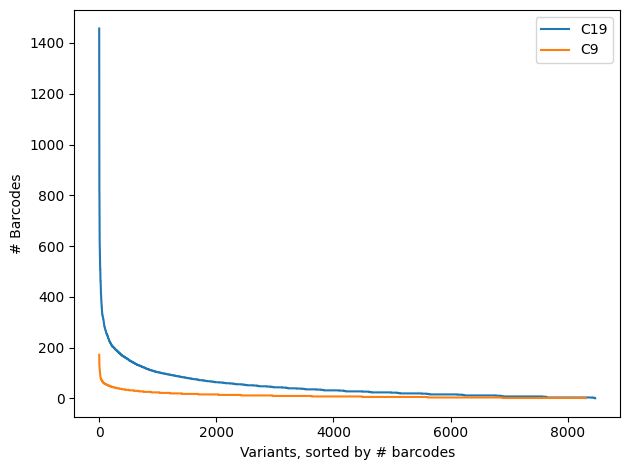

In [40]:
fig, ax = plt.subplots()
for col, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    vc = condition_df.aa_substitutions.value_counts()
#     print(f"{condition} \n{vc[:5]}\n{vc[-5:]}")
    ax.plot(vc.values, label=condition)
    ax.set_ylabel("# Barcodes")
    ax.set_xlabel("Variants, sorted by # barcodes")
#     ax.set_title(condition)
ax.legend()
plt.tight_layout()
plt.show()

Next, let's look at the stoachasticity to expect by number of barcodes

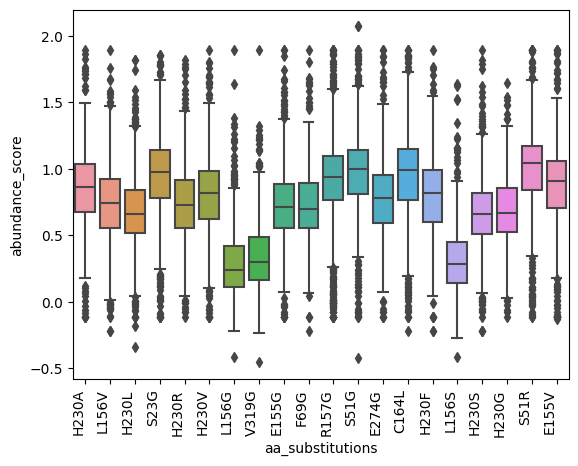

In [41]:
fig, ax = plt.subplots()
subs = func_score_df.aa_substitutions.value_counts()[:20].index
subs_fs = func_score_df.query(f"aa_substitutions.isin({list(subs)})")
sns.boxplot(subs_fs, x="aa_substitutions", y="abundance_score", ax=ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')
plt.show()

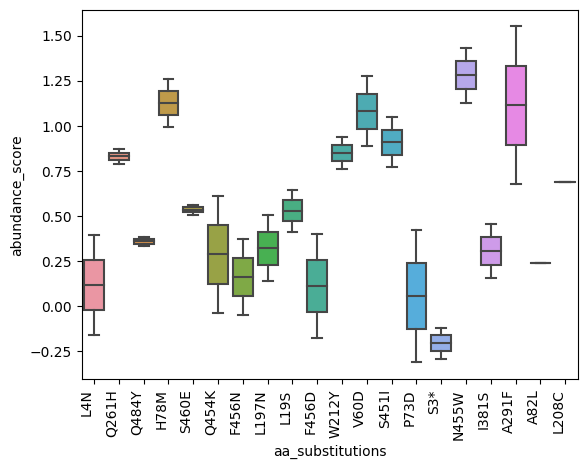

In [42]:
fig, ax = plt.subplots()
subs = func_score_df.aa_substitutions.value_counts()[-20:].index
subs_fs = func_score_df.query(f"aa_substitutions.isin({list(subs)})")
sns.boxplot(subs_fs, x="aa_substitutions", y="abundance_score", ax=ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')
plt.show()

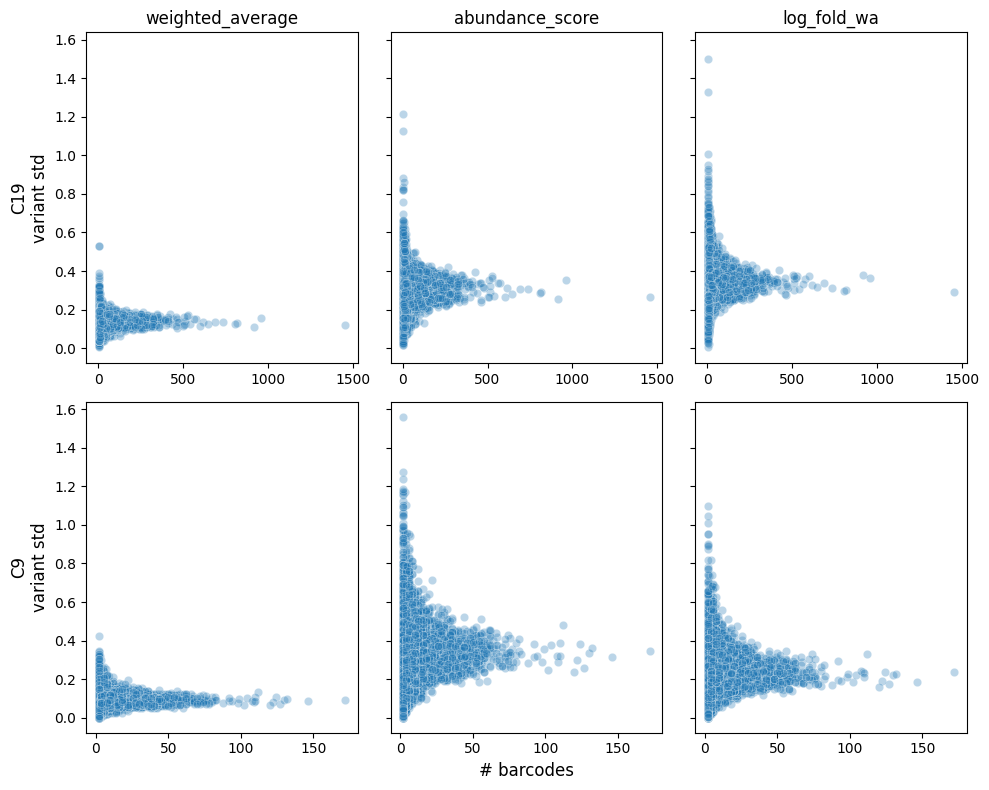

In [43]:
targets = ["weighted_average", "abundance_score", "log_fold_wa"]
fig, ax = plt.subplots(
    len(func_score_df.condition.unique()),
    len(targets),
    sharey=True,
    figsize=[10, 8]
)
for row, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    for col, target in enumerate(targets):
        cv = condition_df.groupby("aa_substitutions").agg({"barcode":lambda x: len(x), target:onp.std})
        sns.scatterplot(cv,x="barcode", y=target, ax = ax[row, col], alpha=0.3)
        ax[row, col].set_xlabel("")
        ax[row, col].set_ylabel("")
        if col == 0:
            ax[row, col].set_ylabel(f"{condition}\nvariant std", size=12)
        if row == 0:
            ax[row, col].set_title(target)
        if row == 1 and col == 1:
            ax[row, col].set_xlabel("# barcodes", size=12)
plt.tight_layout()
plt.show()

## Sweep of lasso params

In [44]:
data = multidms.Data(
    func_score_df.query("replicate != 'Rep1'").rename({"abundance_score":"func_score"}, axis=1),
    reference = "C9",
    collapse_identical_variants = False,
    alphabet= multidms.AAS_WITHSTOP,
    verbose=True
)

inferring site map for C19


  0%|          | 0/421147 [00:00<?, ?it/s]

inferring site map for C9


  0%|          | 0/97873 [00:00<?, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [1, 221, 38, 236],
dropping: 381 variantswhich have mutations at those sites.


invalid non-identical-sites: [3, 50, 184, 206, 243, 295, 362], dropping 5948 variants
Converting mutations for C19


Converting mutations for C9
is reference, skipping


In [45]:
models = pd.DataFrame()

In [79]:
data.condition_colors = {
    'C19': (0.0, 0.4470588235294118, 0.6980392156862745), 
    'C9': (0.0, 0.6196078431372549, 0.45098039215686275)
}
# choose fitting hyper-parameters
fit_params = {
    'init_beta_naught' : 1.0,
    'lock_beta_naught' : 1.0,
    'epistatic_model' : "Identity",
    'output_activation' : "Identity",
    'warmup_beta':False,
    'gamma_corrected':False,
    'alpha_d': False,
    'scale_coeff_ridge_beta':0,
    'scale_coeff_ridge_shift':0,
    'scale_coeff_ridge_gamma':0,
    'scale_coeff_ridge_ch':0,
    'tol':1e-5,
    'save_model_at':[30000],
    'num_training_steps': 30,
    'iterations_per_step':1000
}

for lasso in [0.0, 1e-06, 1e-05, 2e-05, 5e-05, 0.0001]:

    fit_params["scale_coeff_lasso_shift"] = lasso
    start_t = time.time()
    fit = multidms.utils.fit_wrapper(data, **fit_params)
    # fit["replicate"] = replicate
    fit["target"] = "abundance_score"

    models = pd.concat([models, fit], ignore_index=True)
    end_t = time.time()
    print(f"FINISHED total time: {round(end_t - start_t)} seconds")

    print(f"Done")

running:
{'PRNGKey': 0,
 'alpha_d': False,
 'data_idx': 0,
 'dataset': <multidms.data.Data object at 0x7fa630501510>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'huber_scale_huber': 1,
 'init_beta_naught': 1.0,
 'iterations_per_step': 1000,
 'lock_beta': False,
 'lock_beta_naught': 1.0,
 'num_training_steps': 30,
 'output_activation': 'Identity',
 'save_model_at': [30000],
 'scale_coeff_lasso_shift': 0.0,
 'scale_coeff_ridge_beta': 0,
 'scale_coeff_ridge_ch': 0,
 'scale_coeff_ridge_gamma': 0,
 'scale_coeff_ridge_shift': 0,
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 1e-05,
 'warmup_beta': False}
training_step 0/30,Loss: 0.33566434536345735, Time: 89 Seconds
training_step 1/30,Loss: 0.25466041693704106, Time: 87 Seconds
training_step 2/30,Loss: 0.21867663898034095, Time: 87 Seconds
training_step 3/30,Loss: 0.19847636182639294, Time: 87 Seconds
training_step 

2023-08-03 16:13:12.786441: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2461] Execution of replica 0 failed: INTERNAL: Failed to load in-memory CUBIN (compiled for a different GPU?).: CUDA_ERROR_OUT_OF_MEMORY: out of memory


XlaRuntimeError: INTERNAL: Failed to load in-memory CUBIN (compiled for a different GPU?).: CUDA_ERROR_OUT_OF_MEMORY: out of memory

In [64]:
models.loc[0, "model_20000"].data.reference

'C9'

In [65]:
data.condition_colors = {
    'C19': "#e694ae", 
    'C9': "#aad7da"
}

In [66]:
mut_df = multidms.utils.combine_replicate_muts(
    {
        f"lasso_{row.scale_coeff_lasso_shift}" : row.model_20000
        for idx, row in models.iterrows()   
    }
)

In [67]:
mut_df

,wts,sites,muts,lasso_0.0_beta,lasso_1e-06_beta,lasso_1e-05_beta,lasso_2e-05_beta,lasso_5e-05_beta,lasso_0.0001_beta,avg_beta,...,lasso_5e-05_C19_predicted_func_score,lasso_0.0001_C19_predicted_func_score,avg_C19_predicted_func_score,lasso_0.0_C9_predicted_func_score,lasso_1e-06_C9_predicted_func_score,lasso_1e-05_C9_predicted_func_score,lasso_2e-05_C9_predicted_func_score,lasso_5e-05_C9_predicted_func_score,lasso_0.0001_C9_predicted_func_score,avg_C9_predicted_func_score
mutation,,,,,,,,,,,,,,,,,,,,,
D2A,D,2,A,-0.126937,-0.118979,-0.046681,0.037650,0.085996,0.087387,-0.013594,...,1.598096,1.292710,1.380509,-0.126937,-0.118979,-0.046681,0.037650,0.085996,0.087387,-0.013594
D2C,D,2,C,-0.418581,-0.410167,-0.334292,-0.246769,-0.210162,-0.204546,-0.304086,...,1.301938,1.000777,1.150765,-0.418581,-0.410167,-0.334292,-0.246769,-0.210162,-0.204546,-0.304086
D2E,D,2,E,0.174667,0.176444,0.196774,0.197167,0.200631,0.200488,0.191029,...,1.712731,1.405812,1.445269,0.174667,0.176444,0.196774,0.197167,0.200631,0.200488,0.191029
D2G,D,2,G,-0.080048,-0.078032,-0.059532,-0.039078,0.015228,0.097707,-0.023959,...,1.696505,1.303030,1.450561,-0.080048,-0.078032,-0.059532,-0.039078,0.015228,0.097707,-0.023959
D2H,D,2,H,0.170041,0.163430,0.143560,0.140687,0.127106,0.101490,0.141052,...,1.639206,1.306814,1.361529,0.170041,0.163430,0.143560,0.140687,0.127106,0.101490,0.141052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V490G,V,490,G,-0.050839,-0.042691,-0.028817,-0.028398,-0.024439,-0.023637,-0.033137,...,1.487660,1.181686,1.210269,-0.050839,-0.042691,-0.028817,-0.028398,-0.024439,-0.023637,-0.033137
V490L,V,490,L,0.034967,0.033245,0.042617,0.052395,0.055934,0.056040,0.045866,...,1.568034,1.261363,1.306413,0.034967,0.033245,0.042617,0.052395,0.055934,0.056040,0.045866
V490M,V,490,M,-0.039123,-0.031040,0.011666,0.011843,0.015692,0.017712,-0.002208,...,1.527791,1.223035,1.276940,-0.039123,-0.031040,0.011666,0.011843,0.015692,0.017712,-0.002208


In [68]:
mut_df.to_csv("../results/sweep_mut_df.csv")

In [69]:
models

,dataset,huber_scale_huber,scale_coeff_lasso_shift,scale_coeff_ridge_beta,scale_coeff_ridge_shift,scale_coeff_ridge_gamma,scale_coeff_ridge_ch,data_idx,epistatic_model,output_activation,...,init_beta_naught,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_20000,target
0,<multidms.data.Data object at 0x7fa630501510>,1,0.0,0,0,0,0,0,Identity,Identity,...,1.0,False,0.00001,20,1000,[20000],0,"[0.34272298673890306, 0.25846256474694185, 0.2...",<multidms.model.Model object at 0x7fa5185be0d0>,abundance_score
1,<multidms.data.Data object at 0x7fa630501510>,1,0.000001,0,0,0,0,0,Identity,Identity,...,1.0,False,0.00001,20,1000,[20000],0,"[0.34307834909379703, 0.2587016488384148, 0.22...",<multidms.model.Model object at 0x7fa710aa8f50>,abundance_score
2,<multidms.data.Data object at 0x7fa630501510>,1,0.00001,0,0,0,0,0,Identity,Identity,...,1.0,False,0.00001,20,1000,[20000],0,"[0.34530886233620506, 0.26080859199653855, 0.2...",<multidms.model.Model object at 0x7fa520c8ba90>,abundance_score
3,<multidms.data.Data object at 0x7fa630501510>,1,0.00002,0,0,0,0,0,Identity,Identity,...,1.0,False,0.00001,20,1000,[20000],0,"[0.3480143448538765, 0.2634441855182254, 0.225...",<multidms.model.Model object at 0x7fa70044b9d0>,abundance_score
4,<multidms.data.Data object at 0x7fa630501510>,1,0.00005,0,0,0,0,0,Identity,Identity,...,1.0,False,0.00001,20,1000,[20000],0,"[0.3547093026054803, 0.2704166869529781, 0.232...",<multidms.model.Model object at 0x7fa716d1c110>,abundance_score
5,<multidms.data.Data object at 0x7fa630501510>,1,0.0001,0,0,0,0,0,Identity,Identity,...,1.0,False,0.00001,20,1000,[20000],0,"[0.36177292629908986, 0.27652832905075986, 0.2...",<multidms.model.Model object at 0x7fa5a4198290>,abundance_score


In [78]:
import pickle
pickle.dump(models, open("beta_alpha_model", "wb"))

In [70]:
# set some global variables
# columns name
model_name = "model_20000"

# the number of times a mutation must be seen in each condition to be included in downstream analysis
times_seen_threshold = 1

# The chosen lasso strength for our final spike model results
chosen_lasso_strength = 0.00001

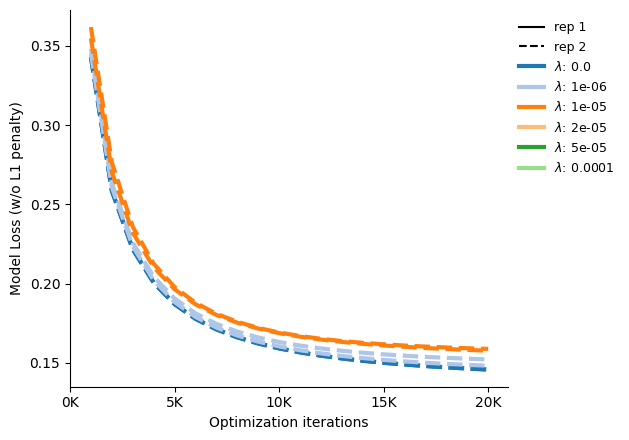

In [71]:
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

saveas="convergence_all_lasso_lines"
cmap=plt.get_cmap("tab20")


fig, ax = plt.subplots(1,figsize=[6.4,4.5])
color_idx = -1
for i, (model, model_row) in enumerate(models.iterrows()):
    if i%2 == 0: color_idx += 1

    ax.plot(
        [1000 * (s+1) for s in range(len(model_row.step_loss))],
        model_row.step_loss,
        c=cmap.colors[color_idx],
        lw=3,
        linestyle="--",
        # linestyle="-" if model_row.replicate == 0 else "--",
        label=f"scale_coeff: {model_row.scale_coeff_lasso_shift}"
    )

ticks = range(0, 20001, 5000)
labels = [f"{t//1000}K" for t in ticks]
ax.set_xticks(ticks, labels, rotation=0, ha='center')
ax.set_ylabel("Model Loss (w/o L1 penalty)")
ax.set_xlabel("Optimization iterations")

black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
lasso_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=5,
        linewidth=3,
        label="$\lambda$: "+str(lasso)
    )
    for lasso, color in zip(models.scale_coeff_lasso_shift.unique(), cmap.colors)
]

elements = [black_line, black_dashed] + lasso_color_handles
ax.legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)
sns.despine(ax=ax)
ax.set_ylim()
plt.tight_layout()
fig.savefig(f"{saveas}.pdf",bbox_inches='tight')
plt.show()

In [72]:
fit_dict = {f"l_{float(row.scale_coeff_lasso_shift)}":row[model_name] for _, row in models.iterrows()}

mut_df = multidms.utils.combine_replicate_muts(
    fit_dict, 
    times_seen_threshold=times_seen_threshold, 
    how="outer"
)

mut_df = pd.melt(
    mut_df.reset_index(), 
    id_vars=["mutation"],
    value_vars=[
        col for col in mut_df.columns 
        if ("_shift_" in col or "beta" in col) and "avg" not in col
    ],
    value_name="S"
)

mut_df = mut_df.assign(
    scale_coeff_lasso=[ 
        v.split("_")[1]
        for v in mut_df.variable
    ],
    sense=[
        "stop" if "*" in mut else "nonsynonymous"
        for mut in mut_df.mutation
    ],
    condition=[
        "C9" 
        if "beta" in v
        else "C19" 
        for v in mut_df.variable
    ],
    # replicate=replicate
)

mut_df.drop("variable", axis=1, inplace=True)
tall_mut_df = mut_df

In [73]:
tall_mut_df

,mutation,S,scale_coeff_lasso,sense,condition
0,D2A,-0.126937,0.0,nonsynonymous,C9
1,D2C,-0.418581,0.0,nonsynonymous,C9
2,D2E,0.174667,0.0,nonsynonymous,C9
3,D2F,0.183612,0.0,nonsynonymous,C9
4,D2G,-0.080048,0.0,nonsynonymous,C9
...,...,...,...,...,...
99127,V490P,0.000000,0.0001,nonsynonymous,C19
99128,V490Q,0.000000,0.0001,nonsynonymous,C19
99129,V490R,0.000000,0.0001,nonsynonymous,C19
99130,V490S,0.000000,0.0001,nonsynonymous,C19


In [74]:
import jax
def loss(model, condition):
    kwargs = {
        'scale_coeff_ridge_beta': 0.,
        'scale_coeff_ridge_shift': 0.,
        'scale_coeff_ridge_gamma': 0.
    }
    
    data = (
        {condition:model.data.training_data["X"][condition]}, 
        {condition:model.data.training_data["y"][condition]}
    )
    
    params = model.get_condition_params(condition)
    return jax.jit(model._model_components["objective"])(model.params, data)

lasso_sparsity_loss = defaultdict(list)
for lasso, lasso_replicates in models.groupby("scale_coeff_lasso_shift"):
    lasso_sparsity_loss["lasso"].append(str(lasso))
    model = lasso_replicates.model_20000.values[0]
    muts_df_outer = model.get_mutations_df(phenotype_as_effect=False)
    muts_df_outer = muts_df_outer.assign(
        sense = [
            "stop" if "*" in mut else "nonsynonymous"
            for mut in muts_df_outer.index.values
        ]
    )

    muts_df_inner = muts_df_outer.dropna()
    for cond in model.data.conditions:
        if cond == model.data.reference:

            rep_cond_shifts = muts_df_outer[[f"beta", "sense"]].dropna()
            for sense, color in zip(["stop", "nonsynonymous"], ["red", "blue"]):
                shifts = rep_cond_shifts.query("sense == @sense")[f"beta"]
                sparsity = (len(shifts[shifts==0]) / len(shifts))*100
                lasso_sparsity_loss[f"{cond}-{sense}-sparsity"].append(sparsity)

        else:
            
            rep_cond_shifts = muts_df_outer[[f"shift_{cond}", "sense"]].dropna()
            for sense, color in zip(["stop", "nonsynonymous"], ["red", "blue"]):
                shifts = rep_cond_shifts.query("sense == @sense")[f"shift_{cond}"]
                sparsity = (len(shifts[shifts==0]) / len(shifts))*100
                lasso_sparsity_loss[f"{cond}-{sense}-sparsity"].append(sparsity)
            

        lasso_sparsity_loss[f"{cond}-loss"].append(loss(model, cond))

lasso_sparsity_loss = pd.DataFrame(lasso_sparsity_loss)
lasso_sparsity_loss

,lasso,C19-stop-sparsity,C19-nonsynonymous-sparsity,C19-loss,C9-stop-sparsity,C9-nonsynonymous-sparsity,C9-loss
0,0.0,6.666667,2.651332,0.0485678225552135,0.0,0.0,0.09732846857191395
1,1e-06,7.826087,4.200969,0.04864802444528122,0.0,0.0,0.09719056634032949
2,1e-05,35.362319,45.629540,0.05102974632853768,0.0,0.0,0.09725626202610886
3,2e-05,57.101449,74.273608,0.053656332888655456,0.0,0.0,0.09857998326029119
4,5e-05,94.492754,95.629540,0.05643395131320254,0.0,0.0,0.10133838767995348
5,0.0001,99.420290,99.225182,0.057001233493060376,0.0,0.0,0.10188559454835956


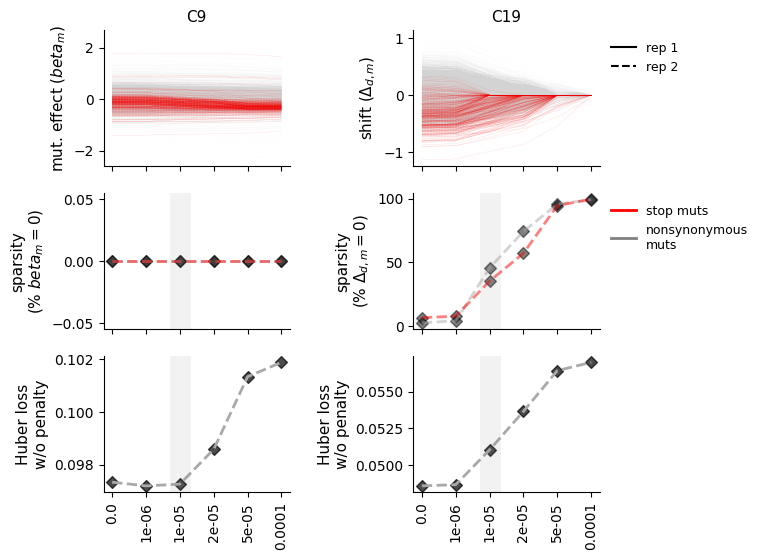

In [76]:
saveas="shrinkage_analysis_trace_plots_beta"
fig, ax = plt.subplots(
    3,3, 
    figsize=[6.4,6],
    sharex=True, 
    gridspec_kw={
        'width_ratios': [1,0.35,1]
    }
)

lasso_cmap=plt.get_cmap("Set2").colors
lasso_shrinkage = sorted(models.scale_coeff_lasso_shift.unique())
lasso_shrinkage_cmap = dict(zip(lasso_shrinkage, lasso_cmap))

# mutations_to_highlight = ["D142L", "A419S", "A570D", "K854N", "T1027I"]
# mutations_cmap=plt.get_cmap("Accent").colors
# mutations_cmap = dict(zip(mutations_to_highlight, mutations_cmap))

condition_col = {
    "C9" : 0,
    "C19" : 2,
}

replicate_line_style = {
    0 : "-",
    1 : "--"
}

replicate_marker = {
    0 : "o",
    1 : "D"
}

sense_colors = {
    "nonsynonymous" : "darkgrey",
    "stop" : "red"
}

sense_lw = {
    "nonsynonymous" : 0.5,
    "stop" : 0.1
}

sense_alpha = {
    "nonsynonymous" : 0.1,
    "stop" : 0.5
}

model_choice = chosen_lasso_strength
model_line_kwargs = {
    "linewidth" : 15,
    "color" : "grey",
    "alpha" : 0.1
}

for condition, df in tall_mut_df.groupby("condition"):
    replicate=1
    row = 0
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
    # plot nonsynonymous, non validated
    for mut, trace_df in df.query(
        "sense == 'nonsynonymous'"
    ).groupby("mutation"):
        iter_ax.plot(
            trace_df.scale_coeff_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=sense_alpha['nonsynonymous'],
            alpha=sense_alpha['nonsynonymous'],
            color="lightgrey"
        )
    
    # plot stop traces
    for mut, trace_df in df.query("sense == 'stop'").groupby("mutation"):

        iter_ax.plot(
            trace_df.scale_coeff_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=sense_lw['stop'],
            alpha=sense_alpha['stop'],
            color=sense_colors['stop']
        )

    # # plot highlighted muts
    # for mut, trace_df in df.query(
    #     "mutation.isin(@mutations_to_highlight)"
    # ).groupby("mutation"):
    #     iter_ax.plot(
    #         trace_df.scale_coeff_lasso, 
    #         trace_df.S,
    #         linestyle=replicate_line_style[replicate],
    #         linewidth=2,
    #         alpha=1.0,
    #         color=mutations_cmap[mut]
    #     )
    # iter_ax.axvline(str(model_choice), **model_line_kwargs)
    
        
    # Plot sparsity    
    row = 1
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
    for sense in ["nonsynonymous", "stop"]:
        iter_ax.plot(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{sense}-sparsity"],
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=0.5,
            color=sense_colors[sense]
        )
        
        iter_ax.scatter(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{sense}-sparsity"],
            marker=replicate_marker[replicate],
            alpha=0.5,
            color="black"
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
        
    # Plot Loss  
    row = 2
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
    
    iter_ax.plot(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-loss"],
        linestyle=replicate_line_style[replicate],
        linewidth=2,
        alpha=1.0,
        color="darkgrey"
    )

    iter_ax.scatter(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-loss"],
        marker=replicate_marker[replicate],
        alpha=0.7,
        color="black"
    )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)



ax[0, 0].set_title("C9", size=11)
ax[0, 2].set_title("C19", size=11)
# ax[0, 3].set_title("BA.2", size=11)

ax[0, 1].set_visible(False)
ax[1, 1].set_visible(False)
ax[2, 1].set_visible(False)

ax[0, 0].set_ylabel("mut. effect ($beta_{m}$)", size=11)
ax[1, 0].set_ylabel("sparsity\n(% $beta_{m} = 0$)", size=11)
# ax[2, 0].set_ylabel("condition\n train data loss \n$L_{Huber_{\sigma=1}}^{d}$ w/o penalty", size=11)
# ax[2, 0].set_ylabel("condition\n training data loss", size=11)
ax[2, 0].set_ylabel("Huber loss\nw/o penalty", size=11)
# ax[3, 0].set_ylabel("$r(beta_{m}^{rep1},beta_{m}^{rep2})$", size=11)

ax[0, 2].set_ylabel("shift $(\Delta_{d,m})$", size=11)
ax[1, 2].set_ylabel("sparsity\n(% $\Delta_{d,m} = 0$)", size=11)
# ax[2, 2].set_ylabel("Huber loss\n w/o penalty", size=11)
ax[2, 2].set_ylabel("Huber loss\nw/o penalty", size=11)
# ax[2, 0].set_ylabel("condition\n training data loss", size=11)



# TODO legends
black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
# lasso_color_handles = [
#     mlines.Line2D(
#         [], [], 
#         color=color, 
#         linestyle='-',
#         markersize=2,
#         linewidth=2,
#         label=mut
#     )
#     for mut, color in mutations_cmap.items()
# ]

elements = [black_line, black_dashed] 
ax[0,2].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

black_circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=5, label='rep 1')
black_triangle = mlines.Line2D([], [], color='black', marker='D', linestyle='None',
                          markersize=5, label='rep 2')

red_line = mlines.Line2D([], [], color='red', linewidth=2,linestyle='-',markersize=5, label='stop muts')
grey_line = mlines.Line2D([], [], color='grey',linewidth=2, linestyle='-',markersize=5, label='nonsynonymous\nmuts')

elements = [red_line, grey_line] #+lasso_color_handles
ax[1, 2].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)


# ax[0,0].text(
#     -0.55, 1.00, 
#     f"A", 
#     ha="right", va="center", 
#     size=15,
#     weight="bold",
#     transform=ax[0,0].transAxes
# )
# ax[1,0].text(
#     -0.55, 1.00, 
#     f"B", 
#     ha="right", va="center", 
#     size=15,
#     weight="bold",
#     transform=ax[1,0].transAxes
# )
# ax[2,0].text(
#     -0.55, 1.00, 
#     f"C", 
#     ha="right", va="center", 
#     size=15,
#     weight="bold",
#     transform=ax[2,0].transAxes
# )

# ax[0, 2].set_yticks([-2.5, 0, 2.5], [-2.5, 0, 2.5])
# ax[0, 2].set_ylim([-3.0, 4.5])
# ax[0, 3].set_yticks([-2.5, 0, 2.5], [-2.5, 0, 2.5])
# ax[0, 3].set_ylim([-3.0, 4.5])
# ax[0, 3].yaxis.set_tick_params(labelleft=False)

# ax[1, 2].set_yticks([0, 50, 100], [0, 50, 100])
# ax[1, 2].set_ylim([-5, 105])
# ax[1, 3].set_yticks([0, 50, 100], [0, 50, 100])
# ax[1, 3].set_ylim([-5, 105])
# ax[1, 3].yaxis.set_tick_params(labelleft=False)

# ax[2, 2].set_yticks([.1, .2, .3], [.1, .2, .3])
# ax[2, 2].set_ylim([.15, .35])
# ax[2, 3].set_yticks([.1, .2, .3], [.1, .2, .3])
# ax[2, 3].set_ylim([.15, .35])
# ax[2, 3].yaxis.set_tick_params(labelleft=False)

ax[2,0].set_xticks(ax[2,0].get_xticks(), ax[2,0].get_xticklabels(), rotation=90, ha='center')
ax[2,2].set_xticks(ax[2,2].get_xticks(), ax[2,2].get_xticklabels(), rotation=90, ha='center')

# plt.tight_layout()
fig.savefig(f"{saveas}.pdf",bbox_inches='tight')
plt.show()